In [2]:
from abc import ABC, abstractmethod
import networkx as nx
import random
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline

## Classes and Helper functions

In [15]:
#Parent Abstract class
class GenericAgent(ABC):
    #Made this an abstract method
    @abstractmethod
    def __init__(self,gid,atype):
        self.plotSpacewidth=3
        
        #Posible state 0-non smoking, 1-smoking, 2-stopped smoking
        self.state=0
        self.next_state=0
        
        #Id in the simulation
        self.gid=gid
        
        if self.state == 0:
            self.state_con = 0.5
        elif self.state == 1:
            self.state_con = 1.5
        elif self.state == 2:
            self.state_con = 0.5
        #Age:
        #self.age = 0
        
        #Agent type
        self._atype=atype
        
        #Probability of starting to smoke per interaction
        self._beta=0
        
        #Probability of stopping to smoke
        self._gamma=0
        
        #Position of the agent in the map (can be ignored, the position is changed when the graph is created)
        self.position=[self.gid%self.plotSpacewidth,self.gid//self.plotSpacewidth]
        
        super().__init__()
    def perceive(self,environment):
        perception=[]
        #The perceptoin consists of the neighbors of the agent and their state
        for neigh in environment.neighbors(self.gid):
            #print("--- ",neigh," state ",G.nodes[neigh]['data'].state)
            perception.append(environment.nodes[neigh]['data'].state)
        return perception
    
    def act(self,perception):
        #Assumed Kermack-McKendrick SIR model
    
        next_state=self.state
        impact_smoke = 0.2
        impact_non = 0.36
        #For every neighbour it interacts with
        for val in perception:
            #if the neighbour smokes, that person will smoke with prob self.beta
            sample=np.random.uniform(0,1)
            if val == 1:
                self.state_con += impact_smoke * sample
            elif val == 2:
                self.state_con -= impact_non * sample
                #if self._beta<sample:
                #    next_state=1
                
        self.next_state = int(self.state_con)
        
        #if the agent itself is smoking, it will stop smoking with probability self.gamma
        #if self.state == 1:
        #    sample=np.random.uniform(0,1)
        #    if self._gamma<sample:
        #        next_state=2
                
        #The states are updated at the end of the timestep        
        #self.next_state=next_state
    
    def update(self):
        #Updating step
        self.state=self.next_state
        #self.age += 1

            
    def info(self):
        print("Agent ",self.gid," of type ",self._atype," state ",self.state, " at position ",self.position)

#Specizalized agent type A (0)        
class AgentA(GenericAgent):
    def __init__(self,gid):
        super().__init__(gid,0)
        self._beta=0.01
        self._gamma=0.01

#Specizalized agent type B (1)
class AgentB(GenericAgent):
    def __init__(self,gid):
        super().__init__(gid,1)
        self._beta=0.05
        self._gamma=0.05
        
    


In [16]:
#This function creates a population of numAgents with percAgents % of Agents type A and the rest type B
def InitializeAgentPolulation():
    AgentList=[]
    numAgents=100
    percAgentsA=0.5
    threasholdA=numAgents*percAgentsA
    for i in range(numAgents):
        if i >= threasholdA:
            AgentList.append(AgentA(i))
        else:
            AgentList.append(AgentB(i))
    for i in range(10):
        AgentList[i].state = 1
    return AgentList

In [17]:
#Prints the info of all agents
def PrintAgentsInfo():
    for agent in AgentList:
        agent.info()

In [18]:
#Plots the interaction graph with the states used as a color map
def PlotGraph(G,color_map=None,ax=None):
    #Extract the positions
    pos = {node[0]: (node[1]['data'].position[0],node[1]['data'].position[1]) for node in G.nodes(data=True)}
    if color_map is None: 
        color_map = [node[1]['data'].state for node in G.nodes(data=True)]
    
    #Change numerical values for colors
    for i in range(len(color_map)):
        if color_map[i] == 0:
            color_map[i] = "red"
        elif color_map[i] == 1:
            color_map[i] = "green"
        elif color_map[i] == 2:
            color_map[i] = "blue"
        #Added to handle the case if state > 2
        else:
            color_map[i] = "black"
        
    #Plot on a specific figure or not    
    if ax is None:
        nx.draw(G,pos,node_color = color_map, with_labels=True, font_weight='bold', node_size = 1000)
    else:
        nx.draw(G,pos,node_color = color_map, ax=ax, with_labels=True, font_weight='bold', node_size = 1000)

In [19]:
#Generates the interaction maps between the agents
def GenerateFriendshipGraph(AgentList,friend_prob):
    #Create an empty graph
    G=nx.Graph()
    
    #add agents to that graph
    for agent in AgentList:
        G.add_node(agent.gid,data=agent)
    
    #Create links between agents using erdos renyi method
    G_erdos = nx.erdos_renyi_graph(len(G.nodes),friend_prob)
    G.add_edges_from(G_erdos.edges())

    #Update the position of the agents for a nicer visualization (only relevant for visualization in the current code)
    pos = nx.random_layout(G, dim=2)    
    for i in range(len(AgentList)):
        AgentList[i].position[0]=pos[i][0]
        AgentList[i].position[0]=pos[i][1]
        
    #IDEA: Create multiple networks for each kind of relationship (e.g co-workers, siblings)
    
    return G

In [20]:
def step(AgentList,Environment):
    #Agents need to be shuffled to eliminate the unrealistic advantage of having a lower gid
    shuffle(AgentList)
    
    #Execute all agents
    for agent in AgentList:
        #print("Executing agent ",agent.gid)
        perception = agent.perceive(Environment)
        agent.act(perception)
    #Update all agents
    for agent in AgentList:
        agent.update()
        #agent.info()

In [21]:
def simulate(AgentList,Environment,numSteps):
    #Store the initial state
    simResults=[[node[1]['data'].state for node in Environment.nodes(data=True)]]
    
    #Perform numSteps number of steps
    for i in range(numSteps):
        #print("Step ",i," of numSteps")
        step(AgentList,Environment)
        #Store results
        states = [node[1]['data'].state for node in Environment.nodes(data=True)]
        simResults.append(states)
    ExportGraph(Environment)
    return simResults

In [22]:
def ExportGraph(Environment):
    env = Environment.copy()
    agent_dict = nx.get_node_attributes(env, 'data')
    for key in agent_dict:
        agent_dict[key] = agent_dict[key].state
    nx.set_node_attributes(env, agent_dict, 'data')
    nx.write_gexf(env,"text.gexf")

## Create Model 

Agent  0  of type  1  state  1  at position  [0, 0]
Agent  1  of type  1  state  1  at position  [1, 0]
Agent  2  of type  1  state  1  at position  [2, 0]
Agent  3  of type  1  state  1  at position  [0, 1]
Agent  4  of type  1  state  1  at position  [1, 1]
Agent  5  of type  1  state  1  at position  [2, 1]
Agent  6  of type  1  state  1  at position  [0, 2]
Agent  7  of type  1  state  1  at position  [1, 2]
Agent  8  of type  1  state  1  at position  [2, 2]
Agent  9  of type  1  state  1  at position  [0, 3]
Agent  10  of type  1  state  0  at position  [1, 3]
Agent  11  of type  1  state  0  at position  [2, 3]
Agent  12  of type  1  state  0  at position  [0, 4]
Agent  13  of type  1  state  0  at position  [1, 4]
Agent  14  of type  1  state  0  at position  [2, 4]
Agent  15  of type  1  state  0  at position  [0, 5]
Agent  16  of type  1  state  0  at position  [1, 5]
Agent  17  of type  1  state  0  at position  [2, 5]
Agent  18  of type  1  state  0  at position  [0, 6]
Age

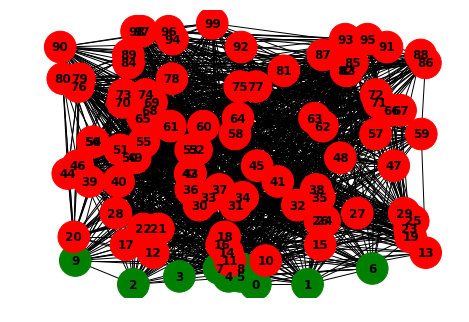

In [23]:
AgentList=InitializeAgentPolulation()
PrintAgentsInfo()
friend_prob=0.3
Environment=GenerateFriendshipGraph(AgentList,friend_prob)
PlotGraph(Environment)

## Execute Simulation

In [27]:
results=simulate(AgentList,Environment,20)

## Visualize Results

In [25]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
import numpy as np
from copy import deepcopy

# Build plot
fig, ax = plt.subplots(figsize=(6,4))
resultsCopy= deepcopy(results)

def animate(j):
    ax.clear()
    PlotGraph(Environment,color_map=resultsCopy[j],ax=ax)
    

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(results))



In [26]:
ani